### building blocks for quick activity detector on neuropixels. 
The code here should:
    - read a sglx file (spikes, ain and d_in) into an array
    - find the triggers
    - filter and CAR the spikes channel
    - get peri_triger thresholded supra-threshold events
    - make psths/rasters
    - determine which N channels have events, and which are 'silent'
    - bring in the probe file
    - make a probe file including these channels.

In [1]:
import numpy as np
import logging
import socket
import glob
import os
import matplotlib.pyplot as plt

from importlib import reload

from intan2kwik import kwd

#mountainsort imports (for sorting)
#import mountainlab_pytools.mlproc as mlp



# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)
        
logger.info('Logger set')
logger.info('Hostname {}'.format(socket.gethostname()))

2019-05-28 23:48:36,678 - root - INFO - Logger set
2019-05-28 23:48:36,679 - root - INFO - Hostname zpikezorter


#### read single sglx file

In [2]:
from pipefinch.pipeline import filestructure as et
reload(et)
reload(kwd)

# sess_par = {'bird': 'p14r14',
#            'sess': '2019-02-14_2250_01'}
sess_par = {'bird': 'p14r14',
           'sess': '2019-02-15_3125_01',
           'probe': 'probe_0', # probe to sort ('probe_0', 'probe_1') (to lookup in the rig_par which port to extract)
           'sort': 1}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sess_par['sort'])
# convenient paths
raw_folder = exp_struct['folders']['raw']

##### make the sgl file structure and retrieve bin and meta files

In [10]:
sess_folder = '/mnt/microdrive/birds/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0'
all_probe_folders = glob.glob(os.path.join(sess_folder, '*'))
all_probe_folders

['/mnt/microdrive/birds/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_t0.nidq.bin',
 '/mnt/microdrive/birds/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_t0.nidq.meta',
 '/mnt/microdrive/birds/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_imec0']

In [9]:
# continue with pipefinch.pipeline.sglxutil

##### read the meta and determine samplerate, number of channels, and channels

In [10]:
# do it, continue with pipefinch.pipeline.sglxutil

##### memmap the file

#### The imec file.
Here's the meaning of some of the metadata https://github.com/JaneliaSciComp/JRCLUST/wiki/.meta-file.
In particular, there is an explanation of what channels in the probe are used and where they are located in the block.
More detailed meta here https://github.com/billkarsh/SpikeGLX/blob/master/Markdown/Metadata.md.

In [67]:
bin_file_path = os.path.join('/mnt/microdrive/birds/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_imec0', '2019-05-27_stimsim_0000_00_g0_t0.imec0.ap.bin')
# these should come from the .meta file
n_chan = 385 #nSavedChans in meta file
s_f = 30000.533148 #imSampleRate in meta file

data_mmap = np.memmap(bin_file_path, dtype='int16', mode='r').reshape(n_chan, -1, order='f')
n_sample = data_mmap.shape[1]
t_ms = np.arange(n_sample)/s_f * 1000

# this yields an array shaped [n_ch, n_sample]

In [68]:
bin_file_path

'/mnt/microdrive/birds/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/2019-05-27_stimsim_0000_00_g0_imec0/2019-05-27_stimsim_0000_00_g0_t0.imec0.ap.bin'

In [69]:
data_mmap.shape

(385, 1695813)

In [70]:
data_mmap

memmap([[22, 21, 24, ..., 18, 18, 21],
        [ 9, 12, 13, ...,  3,  3,  3],
        [72, 72, 72, ..., 65, 65, 63],
        ...,
        [75, 70, 71, ..., 61, 57, 55],
        [95, 98, 97, ..., 96, 93, 91],
        [64, 64, 64, ...,  0,  0,  0]], dtype=int16)

In [71]:
#### The last channel in both the ap and the lf binaries 

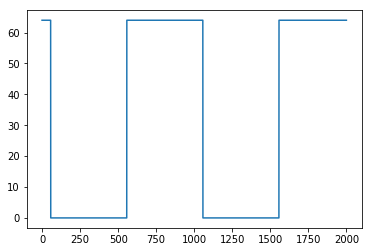

In [72]:
plot_ms = 2000
plt.plot(t_ms[t_ms<plot_ms], data_mmap[-1, t_ms<plot_ms])

#### same for the nidq file
More detailed meta here https://github.com/billkarsh/SpikeGLX/blob/master/Markdown/Metadata.md.
- 

In [188]:
bin_file_path = os.path.join('/mnt/microdrive/birds/stimsim/Ephys/2019-05-27_stimsim_0000_00_g0/', '2019-05-27_stimsim_0000_00_g0_t0.nidq.bin')
#bin_file_path = '/mnt/microdrive/birds/neuropixtests/run1_g0/run1_g0_t0.nidq.bin'
# these should come from the .meta file
n_chan_nidq = 9 #nSavedChans in meta file
s_f_nidq = 20000.190251 #nidqSampleRate in meta file
n_chan_tuple = (0, 0, 8, 1) #acqMnMaXaDw - The two last are the relevant. We have no multiplexed channels (Whisper system); those will always be zeros, or should be.
n_adc_chan = n_chan_tuple[2]
n_dig_word = n_chan_tuple[3]

data_mmap_nidq = np.memmap(bin_file_path, dtype='int16', mode='r').reshape(n_chan_nidq, -1, order='f')
n_sample_nidq = data_mmap_nidq.shape[1]
t_ms_nidq = np.arange(n_sample_nidq)/s_f_nidq * 1000
# this yields an array shaped [n_ch, n_sample]

In [189]:
# so get the digital channels
dig_arr = np.unpackbits(data_mmap_nidq[-1].astype(np.uint8))
dig_arr.dtype

dtype('uint8')

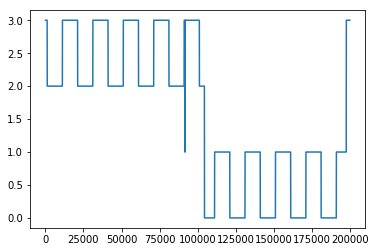

In [191]:
dig_stream = data_mmap_nidq[-1].astype(np.uint8)
dig_stream.shape
plt.plot(dig_stream[:20000*10])

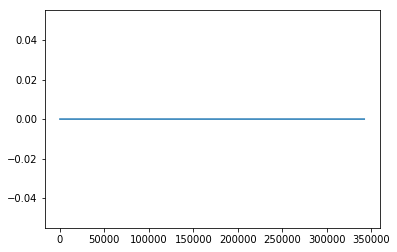

In [187]:
plt.plot(np.unpackbits(dig_stream).reshape(8, -1, order='f')[0])

In [179]:
dig_arr = np.unpackbits(np.expand_dims(dig_stream, 1), axis=1)
dig_arr.shape

(342387, 8)

In [180]:
dig_arr

memmap([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [181]:
dig_arr

memmap([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

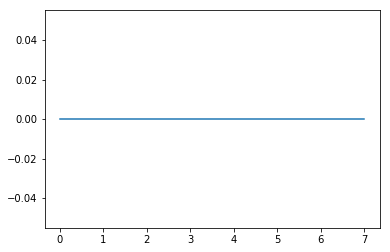

In [182]:
plt.plot(dig_arr[1, :20000])

In [86]:
#plot syn channels and check alignment

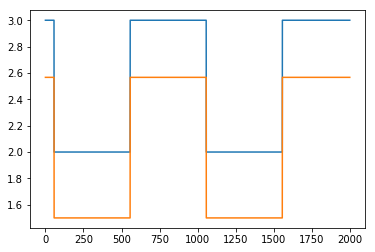

In [84]:
plot_ms = 2000
plt.plot(t_ms_nidq[t_ms_nidq<plot_ms], data_mmap_nidq[-1, t_ms_nidq<plot_ms])
plt.plot(t_ms[t_ms<plot_ms], data_mmap[-1, t_ms<plot_ms]/60+1.5)

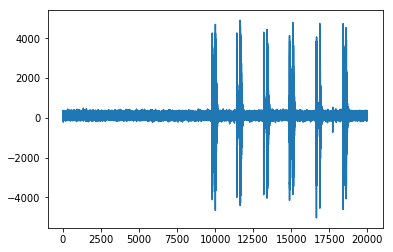

In [94]:
# plot mic chan
mic_chan = 0
plot_ms = 20000
plt.plot(t_ms_nidq[t_ms_nidq<plot_ms], data_mmap_nidq[mic_chan, t_ms_nidq<plot_ms])

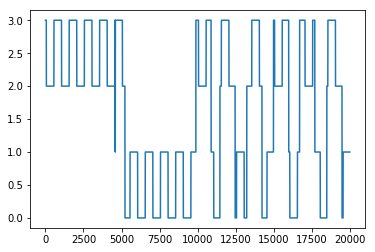

In [96]:
# dig into the digital channels?
plt.plot(t_ms_nidq[t_ms_nidq<plot_ms], data_mmap_nidq[-1, t_ms_nidq<plot_ms])